In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MultipleLocator
from astropy import units as u

import pulsar

# Pulsar Profiling

In this project we use computational techniques to simulate and plot a pulsar
profile in which its observed brightness follows the von Mises distribution,
a continuous probability distribution on a circular plane with a range from 0
to 2 $\pi$.

This profile represents a pulsar in a binary system in which its orbiting
companion decreases the observed brightness at regular intervals. The observed 
brightness is defined as:

$$I(\phi \, | \, \mu,\kappa) = I_{peak}e^{\kappa\, cos(\phi-\mu)}$$

Where:

* $\phi$ is the pulsar phase which depends on its angular frequency
* $I_{peak}$ is the peak observed brightness
* $\mu$ is the mean direction of the distribution ($0 \leq \mu \leq 2 \pi$)
* $\kappa$ is the concentration parameter, the reciprocal of dispersion,
defined as:

$$\kappa = \frac{log \, 2}{2\, sin^2(\pi D/2)}$$

When $\kappa = 0$ the distribution is uniform, but for a pulsar its
concentration value depends on $D$, the duty cycle. The duty cycle is the ratio
of pulse width to the period of repetition of the pulse.

Examples of duty cycles of detected pulsars (Henry and Paik, 1969):

<div>
<img src="dutycycle.png" alt="Duty Cycles" width="400px">
</div> 

References:

* Grafarend, E. & Awange. J. (2012) Applications of Linear and Nonlinear Models:
Fixed Effects, Random Effects. Springer Science & Business Media, Aug 15.
(p. 362)
* Henty, G., Paik, HJ. Distribution of Pulsar Duty Cycles. Nature 224, 1188–1189
(1969). https://doi.org/10.1038/2241188a0

## Scenario Constants

For this project we use the following constants for the observed intensity
function:

* $\phi_{0} = 1$ ($\phi$ at $t_0$)
* $I_{peak} = 100$ 
* $\mu = 1$
* $D = 0.1$
* T = 10ms which results in a frequency $\approx 1.6$ kHz, $53\times$ faster than the
    Crab Nebula

In [7]:
# Global settings for plot size
plt.rcParams["figure.figsize"] = (20, 5)

# Pulsar scenario constants
D = 0.1             # duty cycle number
phi0 = 1 * u.rad    # initial angle value
Ipeak = 100         # amplitude of intensity
period = 0.01 * u.s # rotational period (10 ms)

## Simulated brightness time series

Using the scenario constants we simulate a time series from 0 to 2s with
1000 data points (2ms sample rate).

The first plot shows the entire 2s period in which we can see the observed
brightness varying from its highest peak at $I(t=0) \approx 1.4 \cdot 10^8$
from its lowest peak at $I(t=1s) \approx 9^6$.
The interpretation is that dimming in brightness in the pulsar radiation is
caused by the orbiting companion moving in front of the signal from Earth's
view point.

The next two plots show individual pulses at its highest and lowest observed
brightness. From both images we can see one pulse for each rotational period
(0.01s).

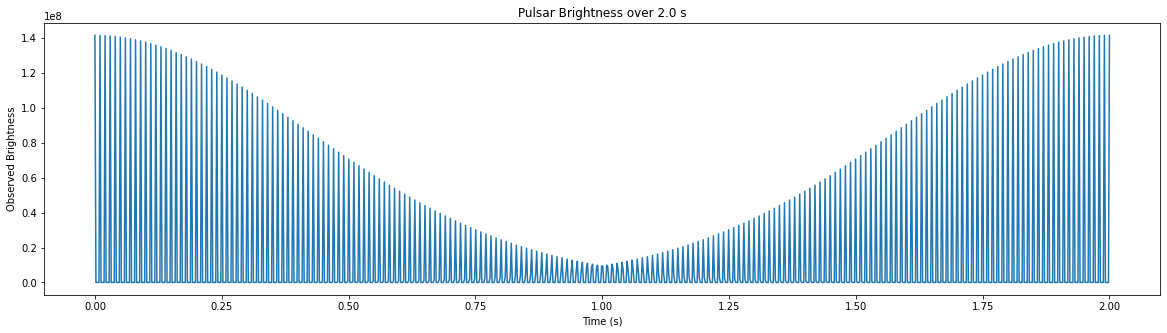

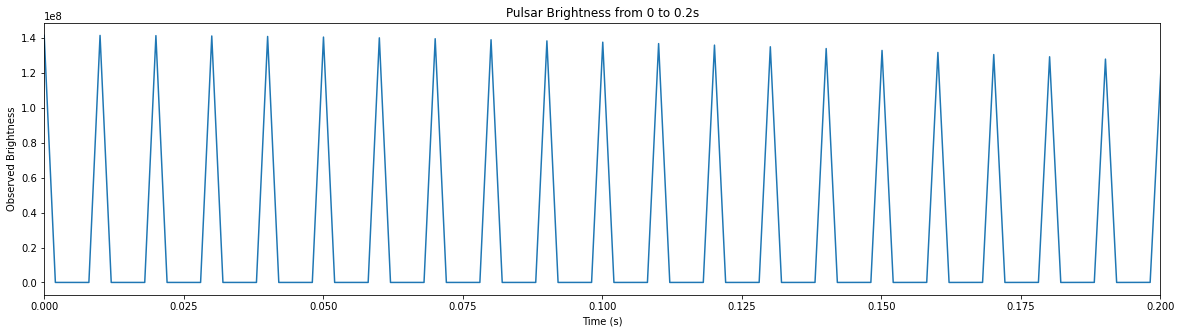

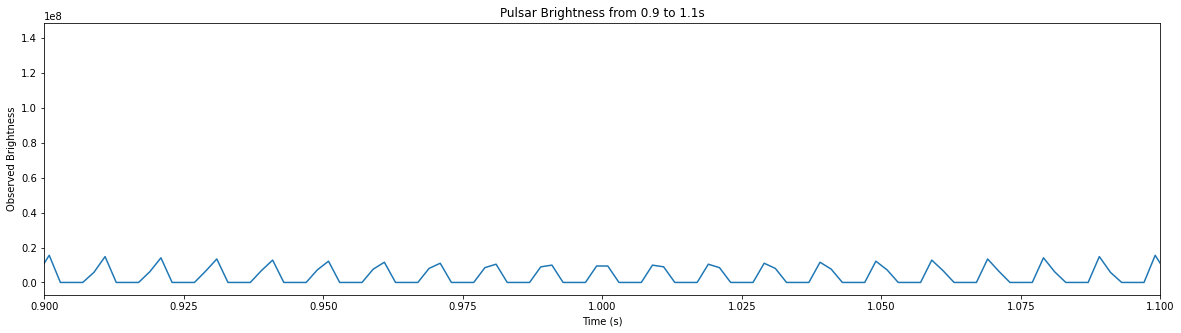

In [8]:
time = 2 * u.s

def plot_brightness(time: u.s, sample_rate: int, xlim=()):

    tframe = np.linspace(0, time.value, num=sample_rate) * u.s
    brightness = pulsar.linear_brightness(phi0, D, period, Ipeak, tframe)

    plt.plot(tframe, brightness)
    plt.xlabel('Time (s)')
    plt.ylabel('Observed Brightness')
    if len(xlim) == 2:
        min = xlim[0]
        max = xlim[1]
        plt.xlim(xlim[0], xlim[1])
        plt.title(f'Pulsar Brightness from {min} to {max}s')
    else:
        plt.title(f'Pulsar Brightness over {time}')
    plt.show()

plot_brightness(time, 1000)
plot_brightness(time, 1000, (0, 0.20))
plot_brightness(time, 1000, (0.9, 1.1))

## Integrated Brightness

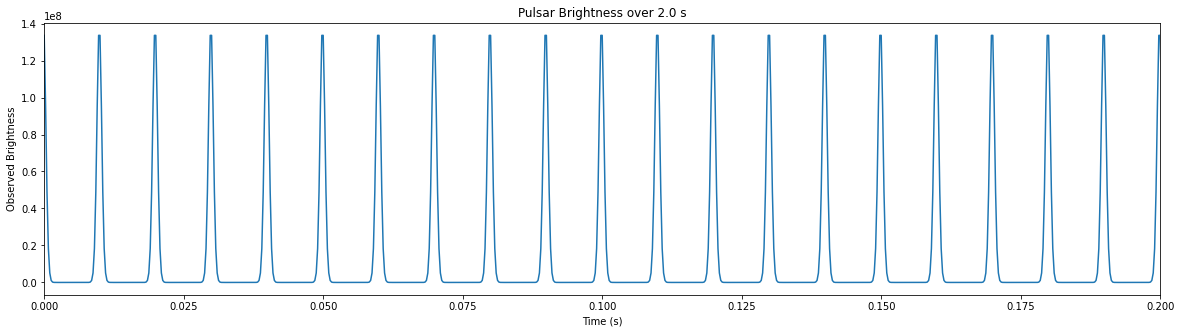

In [9]:
# Integrate the brigthness with a time step of 0.25ms
ts = 0.00025 * u.s # 0.25ms
steps = np.arange(0, time.value, ts.value)

brightness = pulsar.integrated_brightness(phi0, D, period, ts, Ipeak, steps)

plt.plot(steps[:-1], brightness)
plt.title(f'Pulsar Brightness over {time}')
plt.xlabel('Time (s)')
plt.ylabel('Observed Brightness')
plt.xlim(0, 0.2)
plt.show()

## Adding noise

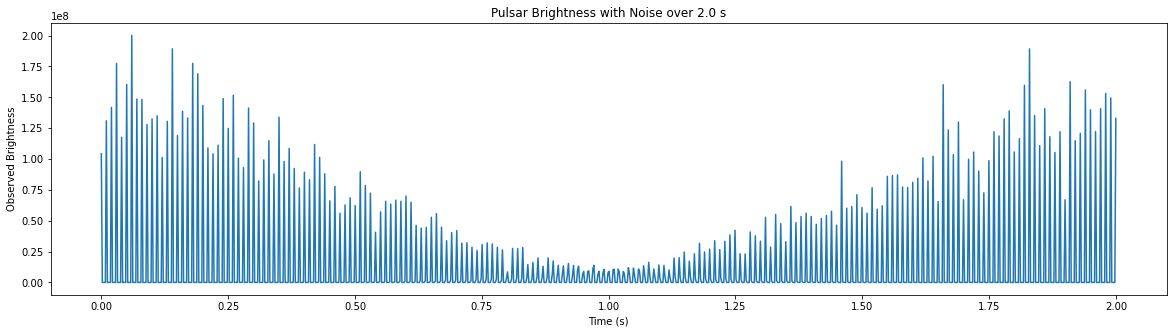

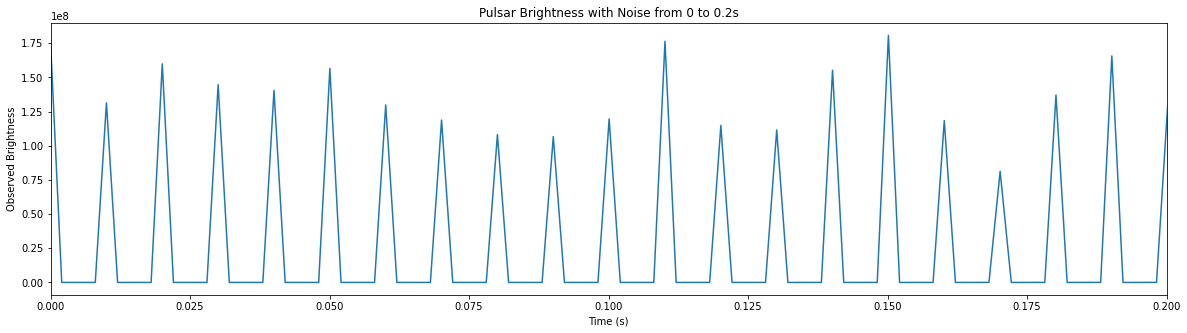

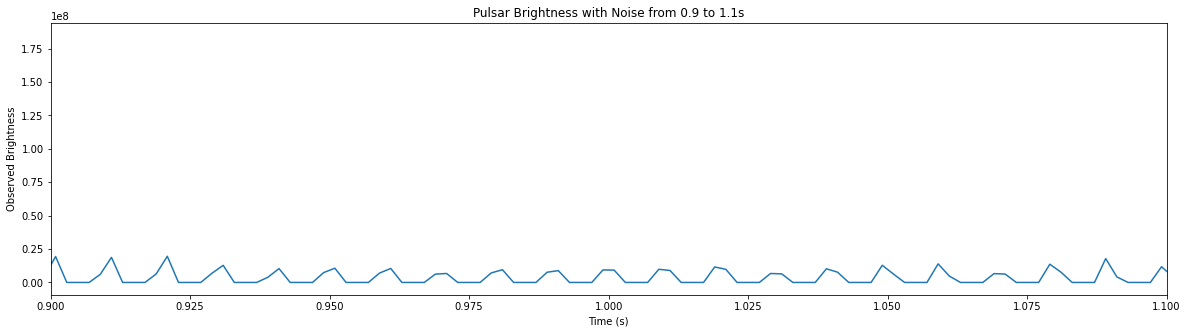

In [10]:
def plot_noisy_brightness(time: u.s, sample_rate: int, xlim=()):

    stddev = Ipeak * 0.2
    tframe = np.linspace(0, time.value, sample_rate) * u.s
    brightness = pulsar.noisy_brightness(phi0, D, period, Ipeak, stddev, tframe)

    plt.plot(tframe, brightness)
    plt.xlabel('Time (s)')
    plt.ylabel('Observed Brightness')
    if len(xlim) == 2:
        min = xlim[0]
        max = xlim[1]
        plt.xlim(xlim[0], xlim[1])
        plt.title(f'Pulsar Brightness with Noise from {min} to {max}s')
    else:
        plt.title(f'Pulsar Brightness with Noise over {time}')
    plt.show()

plot_noisy_brightness(time, 1000)
plot_noisy_brightness(time, 1000, (0, 0.20))
plot_noisy_brightness(time, 1000, (0.9, 1.1))